In [3]:
from IPython.core.display import HTML
HTML("<style>.container { width:98% !important; }</style>")

In [4]:
colors=[(0.368417, 0.506779, 0.709798), (0.880722, 0.611041, 0.142051), (0.560181, 0.691569, 0.194885), (0.922526, 0.385626, 0.209179),(0.2,0.2,0.2),(155.0/255,69.0/255,213.0/255)]
def darker(color):
    return (color[0]*0.5,color[1]*0.5,color[2]*0.5)
#!/usr/bin/env python
import pandas as pd
from theano import *
import theano.tensor as T
from theano.ifelse import ifelse
from theano import pp
import numpy as np
import numpy
import copy
import cPickle
import gzip
import collections

import src.mlfg_final as mlfg_div
from src.utils import *
import src.model_selection_val_sparsity as model_sel
import src.noise as noise
from src.graph_div import *

import pylab
from pylab import subplot,subplot2grid,figure,plot,matshow
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def getRuns(header,data,key,typeconv, value):
    return [d for d in data if typeconv(d[getIdx(header,key)])==value]

# F0

In [6]:
def F0(x):
    x1,x2,x3,x4 = x
    return [(np.sin(x1*np.pi)+np.sin(x2*np.pi*2+np.pi/8)+x2-x3*x4)/3.0]

In [7]:
#f = gzip.open("data/fg3-12k.dat.gz", 'rb')
f = gzip.open("data/f0-n-10k-1.dat.gz", 'rb')

data = cPickle.load(f)
base="result_f0-EQLDIV/"

(runs,comments)=readCSVTable(base + "all.dat")
header=comments[0][0].split(' ')
assert(header[0]=="#C")
header = header[1:]
print header
print len(runs)

['k', 'iter', 'layers', 'epochs', 'nodes', 'lr', 'L1', 'L2', 'shortcut', 'batchsize', 'regstart', 'regend', 'id', 'dataset', 'gradient', 'numactive', 'bestnumactive', 'bestepoch', 'runtime', 'extrapol1', 'extrapol2', 'extrapol3', 'extrapolbest1', 'extrapolbest2', 'extrapolbest3', 'valerror', 'valerrorbest', 'testerror']
25


In [8]:
best_instance = model_sel.select_instance(base + "all.dat")

lines:  25
(' best extrapolating model: (only for information):', (1, 9.94299902638e-05))
selected instance model: score: 0.00318949593359 id: 1 #active: 4.0	 val-error: 0.000102293056778	 extra-pol2-error: 9.94299902638e-05


In [9]:
best_instance

{'extrapol2': 9.94299902638e-05,
 'id': 1,
 'num_active': 4.0,
 'score': 0.0031894959335853797,
 'valerror': 0.000102293056778}

In [10]:
runid = best_instance['id']
state = cPickle.load(open(base + str(runid) + ".last_state","rb"))
runparams=getRuns(header,runs,"id",int, runid)[0]
" ".join(runparams)

'99999999999 0 3 4000 10 0.01 0.000316227766017 0.0 False 20 500 3500 1 data/fg1a-n-10k-1.dat.gz sgd 4 4 3800 18.5196628531 9.99167471211e-05 9.94299902638e-05 9.80261459605e-05 9.93677612041e-05 0.000235331374806 0.000968852830731 0.000102293056778 0.000100712484516 inf'

In [11]:
reload(mlfg_div)
#reload(mlfg_redexp)
trained = mlfg_div.test_mlfg(datasets=data,n_epochs=0,verbose=False,learning_rate=0.005, basefuncs1=[0,1,2],
                        L1_reg=float(runparams[getIdx(header,"L1")]),L2_reg=float(runparams[getIdx(header,"L2")]),reg_start=0,
                        n_layer=int(runparams[getIdx(header,"layers")]), n_per_base=int(runparams[getIdx(header,"nodes")]),
                        classifier=None, gradient=runparams[getIdx(header,"gradient")],
                        init_state=state)

Max input value is:  0.999978213817
... building the model
Gradient: sgd
... training
Optimization complete. Best validation score of inf obtained at epoch 1, with test performance 0.000000 


The code for file mlfg_final.pyc ran for 0.00m


NumActive: 4
1.98206528607e-06


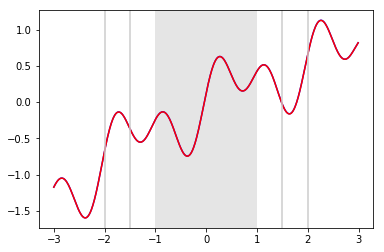

In [13]:
classifier_c = trained["classifier"]
classifier_c.set_state(state)
print "NumActive:",classifier_c.get_num_active_units()
xs = np.arange(-3,3,0.01)
inputs=np.asarray([[x,x,x,0.1*x] for x in xs])
outputs=np.asarray([F0(x) for x in inputs])
cout=classifier_c.evaluate(inputs)

print np.mean((cout[:,0]-outputs[:,0])**2)
plot(xs,cout[:,0],c='b')
plot(xs,outputs[:,0],c='r')
pylab.axvspan(-1,1, facecolor='0.8', alpha=0.5)
for extra in [1.5,2.0]:
    pylab.axvline(-extra*1,c='0.8')
    pylab.axvline(extra*1,c='0.8')
#inputs.shape

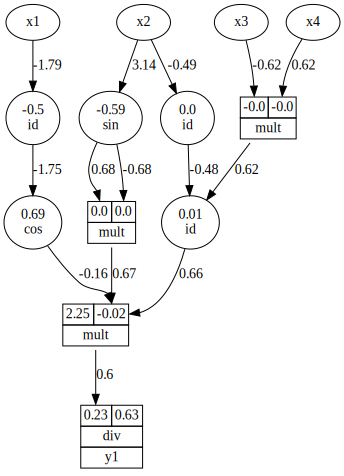

In [14]:
g=functionGraph(classifier_c,0.05)
g

1/3(sin(pi x1) + sin(2 pi x2 + pi/8) + x2 - x3*x4)

In [15]:
g.render('graphics/f0-3layer')

'graphics/f0-3layer.pdf'